## 1. Import Dependencies

In [500]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from numpy import mean
from numpy import std
from numpy import absolute
from pandas import read_csv
from sklearn.linear_model import Ridge
from sklearn import svm
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredLogarithmicError
from sklearn import metrics
#from sklearn.model_selection import RepeatedKFold

%matplotlib inline

#### Load Data from CSV file

In [126]:
data = pd.read_csv("recs2009_public.csv", low_memory = False)

In [127]:
data.head()

,DOEID,REGIONC,DIVISION,REPORTABLE_DOMAIN,TYPEHUQ,NWEIGHT,HDD65,CDD65,HDD30YR,CDD30YR,...,SCALEKER,IECC_Climate_Pub,HDD50,CDD80,GND_HDD65,WSF,OA_LAT,GWT,DesignDBT99,DesignDBT1
0,1,2,4,12,2,2471.68,4742,1080,4953,1271,...,-2,4A,2117,56,4250,0.48,6,56,9,96
1,2,4,10,26,2,8599.17,2662,199,2688,143,...,-2,3C,62,26,2393,0.61,0,64,38,73
2,3,1,1,1,5,8969.92,6233,505,5741,829,...,-2,5A,2346,49,5654,0.48,3,52,12,88
3,4,2,3,7,2,18003.64,6034,672,5781,868,...,-2,5A,2746,0,4941,0.55,4,55,7,87
4,5,1,1,1,3,5999.61,5388,702,5313,797,...,-2,5A,2251,0,5426,0.61,4,50,13,90


## 2. Data Engineering (Cleaning, Assertion of DataTypes, Encoding and Train, test and validation split and scaling)

### Extract 'Imputation flag' columns and drop from the Data

In [128]:
# Define a list to store 'Imputation flag Columns'
imputation_cols = []
# Append imputation flags to the imputation_cols list
for i in data.columns:
    if i.startswith('Z'):
        imputation_cols.append(i)
print(len(imputation_cols))
print(imputation_cols[:20])

359
['ZKOWNRENT', 'ZCONDCOOP', 'ZYEARMADE', 'ZYEARMADERANGE', 'ZOCCUPYYRANGE', 'ZCONVERSION', 'ZORIG1FAM', 'ZLOOKLIKE', 'ZNUMFLRS', 'ZNUMAPTS', 'ZWALLTYPE', 'ZROOFTYPE', 'ZSTUDIO', 'ZNAPTFLRS', 'ZSTORIES', 'ZTYPEHUQ4', 'ZBEDROOMS', 'ZNCOMBATH', 'ZNHAFBATH', 'ZOTHROOMS']


In [129]:
# Drop Imputation flag columns from the dataframe 'data'
data = data.drop(imputation_cols, axis = 1)

In [130]:
data

,DOEID,REGIONC,DIVISION,REPORTABLE_DOMAIN,TYPEHUQ,NWEIGHT,HDD65,CDD65,HDD30YR,CDD30YR,...,SCALEKER,IECC_Climate_Pub,HDD50,CDD80,GND_HDD65,WSF,OA_LAT,GWT,DesignDBT99,DesignDBT1
0,1,2,4,12,2,2471.68,4742,1080,4953,1271,...,-2,4A,2117,56,4250,0.48,6,56,9,96
1,2,4,10,26,2,8599.17,2662,199,2688,143,...,-2,3C,62,26,2393,0.61,0,64,38,73
2,3,1,1,1,5,8969.92,6233,505,5741,829,...,-2,5A,2346,49,5654,0.48,3,52,12,88
3,4,2,3,7,2,18003.64,6034,672,5781,868,...,-2,5A,2746,0,4941,0.55,4,55,7,87
4,5,1,1,1,3,5999.61,5388,702,5313,797,...,-2,5A,2251,0,5426,0.61,4,50,13,90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12078,12079,2,3,9,2,10219.80,7671,332,7784,451,...,-2,6A-6B,4289,39,7819,0.59,0,48,-3,84
12079,12080,3,7,21,4,8689.07,2085,2844,2520,2286,...,-2,3B-4B,360,393,1869,0.50,0,56,26,101
12080,12081,2,4,10,2,4697.21,7935,472,8074,600,...,-2,6A-6B,4494,22,8477,0.58,1,46,-9,89
12081,12082,4,8,23,2,13155.68,5834,770,5989,957,...,-2,5B-5C,2840,0,9010,0.54,1,53,13,93


In [131]:
#Data Types of the dataframe
data.dtypes

DOEID                  int64
REGIONC                int64
DIVISION               int64
REPORTABLE_DOMAIN      int64
TYPEHUQ                int64
                      ...   
WSF                  float64
OA_LAT                 int64
GWT                    int64
DesignDBT99            int64
DesignDBT1             int64
Length: 581, dtype: object

##### As we can see above, the datatypes of all the columns are either int64 or float64. Hence proper data types cannot be determined(categorical and boolean). To understand the data types of features and target vetors, We need to have a look at the provided description given in "recs2009_public_codebook.xlsx" file and extract the columns which are numerical, boolean and categorical. Then we assign the types to the columns.

In [132]:
variable = pd.read_excel("recs2009_public_codebook.xlsx", header = 1, skipfooter = 5)
variable = variable[1:]
variable["Variable Name"] =  variable['Variable Name'].str.strip()
variable.head()

,Variable Name,Variable Description,Response Codes and Labels,Unnamed: 3,Variables in End-Use Models (see note at bottom),Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8
1,DOEID,Unique identifier for each respondent,00001 - 12083,Unique identifier for each respondent,NaN,NaN,NaN,NaN,NaN
2,REGIONC,Census Region,1\n2\n3\n4,Northeast Census Region\nMidwest Census Region...,NaN,NaN,NaN,NaN,NaN
3,DIVISION,Census Division,1\n2\n3\n4\n5\n6\n7\n8\n9\n10,"New England Census Division (CT, MA, ME, NH, R...",NaN,NaN,NaN,NaN,NaN
4,REPORTABLE_DOMAIN,Reportable states and groups of states,1\n2\n3\n4\n5\n6\n7\n8\n9\n10\n11\n12\n13\n14\...,"\nConnecticut, Maine, New Hampshire, Rhode Isl...",NaN,NaN,NaN,NaN,NaN
5,TYPEHUQ,Type of housing unit,1\n2\n3\n4\n5,Mobile Home\nSingle-Family Detached\nSingle-Fa...,OTH_B,SPH_A,NaN,NaN,NaN


In [133]:
#Extract List of Numerical columns from variable codebook
numerical_cols = variable[variable["Response Codes and Labels"].str.contains(' - ', na=True)] #
numerical_cols = numerical_cols["Variable Name"].tolist()

In [134]:
# Extract List boolean columns from variable codebook
boolean_cols = variable[variable["Response Codes and Labels"].isin(['0\n1', '0\n1\n-2'])]
boolean_cols = boolean_cols[~boolean_cols['Variable Name'].isin(imputation_cols)] #Columns that are not imputation flags since imputation_cols contain '0' and '1' values
boolean_cols = boolean_cols['Variable Name'].tolist()

In [135]:
# Extract List of categorical columns from variable cookbook
categorical_cols = variable[variable["Response Codes and Labels"].str.contains('\n', na=False)]
#All columns other than boolean and numerical are categorical columns
categorical_cols = categorical_cols[~categorical_cols['Variable Name'].isin(numerical_cols)]
categorical_cols = categorical_cols[~categorical_cols['Variable Name'].isin(boolean_cols)]
categorical_cols = categorical_cols[~categorical_cols['Variable Name'].isin(imputation_cols)]
categorical_cols = categorical_cols['Variable Name'].tolist()

In [136]:
data[categorical_cols] = data[categorical_cols].astype('category')
data[boolean_cols] = data[boolean_cols].astype('category')

In [137]:
# Check if the data has null/NaN values
print(data.isnull().sum().unique())
print(data.isna().sum().unique())

[0]
[0]


#### Convert boolean and categorical columns to dummy variables and concatenate them with the original dataframe. 

In [138]:
dummies = pd.get_dummies(data[boolean_cols], drop_first=True)
df = data.drop(boolean_cols,axis=1)
df = pd.concat([df,dummies],axis=1)

In [139]:
dummies2 = pd.get_dummies(data[categorical_cols], drop_first=True)
df = data.drop(categorical_cols,axis=1)
df = pd.concat([df,dummies2],axis=1)

In [140]:
df

,DOEID,NWEIGHT,HDD65,CDD65,HDD30YR,CDD30YR,YEARMADE,ORIG1FAM,NUMFLRS,NUMAPTS,...,IECC_Climate_Pub_2B,IECC_Climate_Pub_3A,IECC_Climate_Pub_3B-4B,IECC_Climate_Pub_3C,IECC_Climate_Pub_4A,IECC_Climate_Pub_4C,IECC_Climate_Pub_5A,IECC_Climate_Pub_5B-5C,IECC_Climate_Pub_6A-6B,IECC_Climate_Pub_7A-7B-7AK-8AK
0,1,2471.68,4742,1080,4953,1271,2004,-2,-2,-2,...,0,0,0,0,1,0,0,0,0,0
1,2,8599.17,2662,199,2688,143,1998,-2,-2,-2,...,0,0,0,1,0,0,0,0,0,0
2,3,8969.92,6233,505,5741,829,1965,-2,2,8,...,0,0,0,0,0,0,1,0,0,0
3,4,18003.64,6034,672,5781,868,1985,-2,-2,-2,...,0,0,0,0,0,0,1,0,0,0
4,5,5999.61,5388,702,5313,797,1983,-2,-2,-2,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12078,12079,10219.80,7671,332,7784,451,1985,-2,-2,-2,...,0,0,0,0,0,0,0,0,1,0
12079,12080,8689.07,2085,2844,2520,2286,1980,-2,-2,-2,...,0,0,1,0,0,0,0,0,0,0
12080,12081,4697.21,7935,472,8074,600,1993,-2,-2,-2,...,0,0,0,0,0,0,0,0,1,0
12081,12082,13155.68,5834,770,5989,957,1930,-2,-2,-2,...,0,0,0,0,0,0,0,1,0,0


In [141]:
df['KWH']

0        18466
1         5148
2         2218
3        10015
4         2869
         ...  
12078     7647
12079     1813
12080     9834
12081     4800
12082     1764
Name: KWH, Length: 12083, dtype: int64

In [142]:
df[numerical_cols] = df[numerical_cols].replace({'.': None})

In [143]:
# Drop rest of the null/NaN values
df = df.dropna()

In [144]:
# Determine the feature Variables and target variable from the dataframe
features = df.drop("KWH", axis = 1)
features = df.drop("DOEID", axis = 1) # Drop the DOEID column as it is the ID and does not affect the model in anyway
target = df["KWH"]

In [145]:
# Split the Feature vectors and target vector in training and testing data
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=101)

In [146]:
X_train.isnull().sum().unique()

array([0])

In [147]:
y_test

4643     9540
1525    17031
7422    22105
3070     4631
3900    38871
        ...  
4486    12693
8410     8740
3482     7545
3254     4448
8750    12200
Name: KWH, Length: 3625, dtype: int64

In [462]:
# This function takes in the feature vectors and standardizes with StandardScaler with mean 0 and variance 1.
def dataScaler(data):
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)
    return data_scaled

In [469]:
X_train_scaled = dataScaler(X_train)
X_test_scaled = dataScaler(X_test)

In [470]:
X_train_scaled

array([[-0.60983406, -1.53363878,  2.07411683, ..., -0.20183771,
        -0.29854533, -0.10545336],
       [ 1.38874379, -0.10929327,  0.27295064, ..., -0.20183771,
        -0.29854533, -0.10545336],
       [-0.82741202,  1.73570492, -0.90099216, ..., -0.20183771,
         3.34957507, -0.10545336],
       ...,
       [-0.49030018,  0.63051991, -0.64267166, ..., -0.20183771,
        -0.29854533, -0.10545336],
       [-0.57466667,  0.83004921, -0.70548247, ..., -0.20183771,
        -0.29854533, -0.10545336],
       [-1.17409339,  0.12737785,  0.03232333, ..., -0.20183771,
        -0.29854533, -0.10545336]])

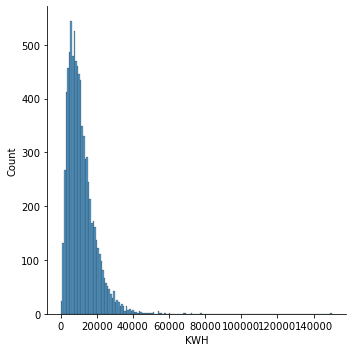

In [625]:
# Check to see if the training and testing target vectors share similar distribution.
sns.displot(y_train)

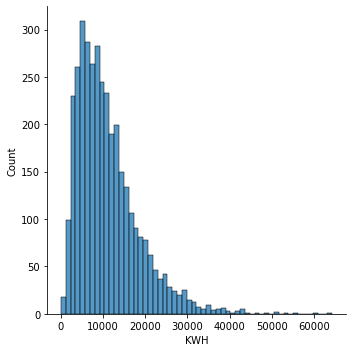

In [465]:
sns.displot(y_test)

Both distributions of target vectors in training and testing dataset exhibits similar patterns. Hence the data set is quite balanced and good for training a model based on it

In [605]:
# This function is defined to perform calculation of perfomance metrics of the model predictors trained
def performance_indicator(y_true, prediction):
    """
    Takes True target values (y_test) and predicted value by each model and renders MAE, MSE, RMSE and R^2 score
    metrics
    """
    print('MAE:', metrics.mean_absolute_error(y_true, prediction))
    print('MSE:', metrics.mean_squared_error(y_true, prediction))
    print('RMSE:', np.sqrt(metrics.mean_squared_error(y_true, prediction)))
    print('R2 score:', r2_score(y_true, prediction))

### 3. Approach to Solution
The given problem is a regression problem. For this problem 3 approaches from 3 different kind of Regression algorithms have been adopted and explored to train a predictor model. 
1. Ridge Linear Regression from Linear Models
2. Random Forest Regression from Ensemble Models
3. Artificial Neural Network based Deep learning Model.

As performance indicators of all the 3 models, 4 metrics were explored namely:
1. Mean Absolute Error
2. Mean Squared Error
3. Root Mean Squared Error
4. R^2 score

We will mainly look at the R^2 score as it is the best statistical variation indicator of two independent variable. We will calculate R^2 score of true target value and predicted value of "KWH" or electric consumption obtained from the trained predictor model.

Then we will look at two plots to determine if the model is performing as modelled.
1. Scatter plot of true target test value (y_test) and predicted value (prediction) from the model. If the scattered plots form a straight line visualization, then the model is said to be performing well with predictions on test data
2. A distribution plot of (y_test - predicted value) to see the range where the differences of predicted value and true test value lies. If it is distrubuted on and sorrounding 0, meaning the model is performing well.

### Ridge Regression and it's performance analysis

In [576]:
def ridge_regressor(alpha):
    """
    Creates a Ridge regression model
    Parameter:
    alpha = Regularization strength; must be a positive float. Regularization
    improves the conditioning of the problem and reduces the variance of
    the estimates. Larger values specify stronger regularization.
    """
    model = Ridge(alpha=alpha)
    return model

In [577]:
ridge = ridge_regressor(alpha = 1)
# Training on X_train scaled and corresponding target y_train
ridge.fit(X_train_scaled, y_train)

Ridge(alpha=1)

In [578]:
predictions = ridge.predict(X_test_scaled)

In [579]:
performance_indicator(y_test, predictions)

MAE: 292.3639254054427
MSE: 172161.6571868893
RMSE: 414.9236763392628
R2 score: 0.9968343795999317


Text(0, 0.5, 'Predicted Y')

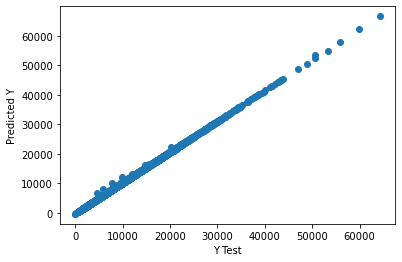

In [587]:
#Scatter plot of true target test value (y_test) and predicted value (prediction) from the model.
plt.scatter(y_test,predictions)
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')

/Users/shadman/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


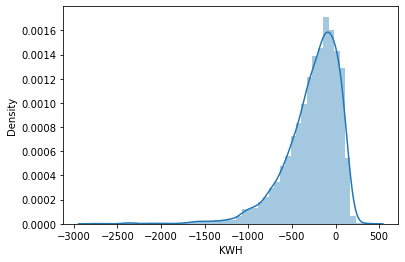

In [588]:
# Distribution plot of (y_test - predicted value) to see the range where the differences of predicted value and true test value lies. 
sns.distplot((y_test-predictions),bins=50);

The distribution plot for Ridge Regressor is almost centered around zero showing most bins are on the negative side. This means the predicted values by the model are mostly slightly larger than the true target values. However, it can be concluded that the models performs really well with predicting the test dataset.

### Random Forest Regression and it's performance analysis

In [589]:
def randomForest_regressor(n_estimators = 500):
    """
    Creates and returns a Random forest regression model.
    Parameter:
    n_estimators = default 500
    The number of trees in the forest
    """
    model = RandomForestRegressor(oob_score = True,  
    random_state = 42,
    max_depth= 15, 
    min_samples_leaf= 1, 
    n_estimators= n_estimators)
    return model

In [590]:
#Creating and fitting the model on training data
rfr = randomForest_regressor()
rfr.fit(X_train_scaled, y_train)

RandomForestRegressor(max_depth=15, n_estimators=500, oob_score=True,
                      random_state=42)

In [591]:
rfr_pred = rfr.predict(X_test_scaled)

In [592]:
performance_indicator(y_test, rfr_pred)

MAE: 323.0946534846196
MSE: 236599.66698578675
RMSE: 486.4151179659065
R2 score: 0.9956495264700751


Text(0, 0.5, 'Predicted Y')

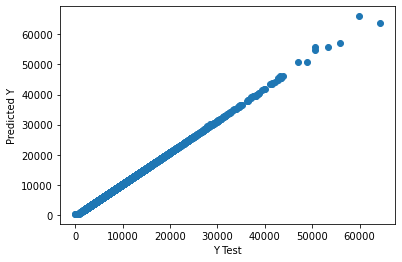

In [593]:
# Scatter plot of true target test value (y_test) and predicted value (prediction) from the model.
plt.scatter(y_test, rfr_pred)
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')

/Users/shadman/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


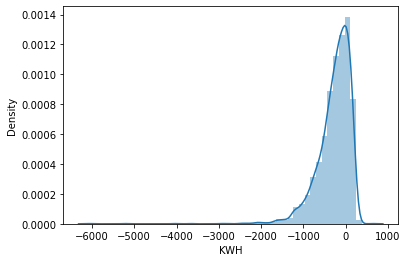

In [594]:
# Distribution plot of (y_test - predicted value) to see the range where the differences of predicted value and true test value lies. 
sns.distplot((y_test-rfr_pred),bins=50);

### Artificial Neural Network Based Deep Learning Model

In [621]:
def ann_model(firstLayer, secondLayer, thirdLayer, fourthLayer, fifthLayer):
    """
    This function creates a 6 layer ANN architecture model configured for this particular problem. It takes 5 arguments
    which are the number of neurons for each layer other than the last layer.
    """
    model = Sequential()

    model.add(Dense(firstLayer, activation = 'relu'))
    model.add(Dropout(0.5))

    model.add(Dense(secondLayer, activation = 'relu'))
    model.add(Dropout(0.5))

    model.add(Dense(thirdLayer, activation = 'relu'))
    model.add(Dropout(0.2))

    model.add(Dense(fourthLayer, activation = 'relu'))
    model.add(Dropout(0.2))
    
    model.add(Dense(fifthLayer, activation = 'relu'))
    model.add(Dropout(0.2))
    

    model.add(Dense(1, kernel_initializer='normal', activation = 'linear'))
    msle = MeanSquaredLogarithmicError()
    model.compile(loss=msle, optimizer = 'adam', metrics=[msle])
    
    return model

In [622]:
ann = ann_model(500, 250, 125, 50, 25)

In [623]:
ann.fit(x=X_train_scaled, y=y_train, epochs = 80, batch_size = 256, validation_data=(X_test_scaled, y_test))

Epoch 1/80
34/34 [==============================] - 1s 19ms/step - loss: 54.5503 - mean_squared_logarithmic_error: 54.5070 - val_loss: 9.0335 - val_mean_squared_logarithmic_error: 9.0390
Epoch 2/80
34/34 [==============================] - 0s 10ms/step - loss: 6.1546 - mean_squared_logarithmic_error: 6.1501 - val_loss: 1.3187 - val_mean_squared_logarithmic_error: 1.3173
Epoch 3/80
34/34 [==============================] - 0s 9ms/step - loss: 1.0805 - mean_squared_logarithmic_error: 1.0794 - val_loss: 0.4529 - val_mean_squared_logarithmic_error: 0.4503
Epoch 4/80
34/34 [==============================] - 0s 9ms/step - loss: 0.4538 - mean_squared_logarithmic_error: 0.4534 - val_loss: 0.3250 - val_mean_squared_logarithmic_error: 0.3223
Epoch 5/80
34/34 [==============================] - 0s 9ms/step - loss: 0.3293 - mean_squared_logarithmic_error: 0.3290 - val_loss: 0.2647 - val_mean_squared_logarithmic_error: 0.2619
Epoch 6/80
34/34 [==============================] - 0s 9ms/step - loss: 0.28

34/34 [==============================] - 0s 10ms/step - loss: 0.0524 - mean_squared_logarithmic_error: 0.0524 - val_loss: 0.0513 - val_mean_squared_logarithmic_error: 0.0499
Epoch 46/80
34/34 [==============================] - 0s 9ms/step - loss: 0.0499 - mean_squared_logarithmic_error: 0.0499 - val_loss: 0.0512 - val_mean_squared_logarithmic_error: 0.0499
Epoch 47/80
34/34 [==============================] - 0s 9ms/step - loss: 0.0490 - mean_squared_logarithmic_error: 0.0490 - val_loss: 0.0513 - val_mean_squared_logarithmic_error: 0.0500
Epoch 48/80
34/34 [==============================] - 0s 10ms/step - loss: 0.0503 - mean_squared_logarithmic_error: 0.0503 - val_loss: 0.0511 - val_mean_squared_logarithmic_error: 0.0498
Epoch 49/80
34/34 [==============================] - 0s 10ms/step - loss: 0.0494 - mean_squared_logarithmic_error: 0.0493 - val_loss: 0.0504 - val_mean_squared_logarithmic_error: 0.0492
Epoch 50/80
34/34 [==============================] - 0s 9ms/step - loss: 0.0465 - me

<AxesSubplot:>

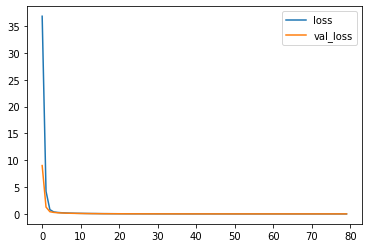

In [624]:
# Plot to assess behavior of training loss and validation loss during training for each epoch to determine if the model
# Over fitting or UnderFitting or Perfectly fitting
losses = pd.DataFrame(ann.history.history)
val = losses['val_loss'] - losses['loss']
losses[['loss','val_loss']].plot()

This ANN model is perfectly fitting. From the validation loss plot below we can determine how the validation loss decresed over the number of epochs. We can conclude that the major drop in validation loss during training happened within the first 6-7 epochs and then the rate of decrement is very minute. 

<AxesSubplot:>

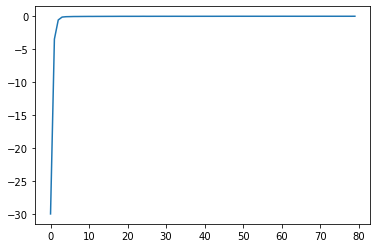

In [612]:
val.plot()

In [614]:
pred = ann.predict(X_test_scaled)

In [615]:
performance_indicator(y_test, pred)

MAE: 981.4138421841326
MSE: 2376045.290101384
RMSE: 1541.44260032652
R2 score: 0.9563104958169287


Text(0, 0.5, 'Predicted Y')

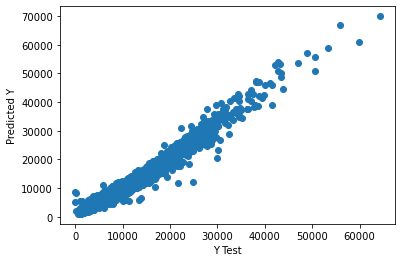

In [616]:
plt.scatter(y_test, pred)
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')

/Users/shadman/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


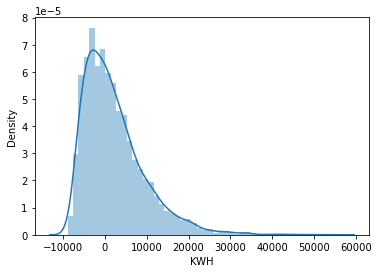

In [619]:
sns.distplot((y_test-pred[0,:]),bins=50);

The Distribution plot shows that the majority of predicted values by ANN model are slightly lower than the true test target value. 

### 4. Analysis and Conclusion
From the performance indicators and the subsequent plots of the predicted and true values:

1. The Ridge Regressor has the highest R^2 score of 0.9968 and lowest MAE of 292.36. However most of the predicted consumtion values are slightly higher than the true values.

2. The Random Forest Regressors with 500 trees has the second highest R^2 score of 0.9956 and MAE of 323.09. Most of the predicted consumtion values are slightly higher than the true values for this model as well but the plot is slighly narrower than the plot for Ridge regression model.

3. ANN model has the lowest R^2 score of 0.9563 and MAE of 981.41 which is the highest. The scatter plot with predicted and true value do show a more scattered but straight line visualtion. And the model seems to have mostly predicted slightly lower values than the target value. ANN model might be performing the worst of the 3 but this model can be improved to perform a lot better with more hyperparameter tuning and testing. This will render a more generalized model to predict the power consumption based on the given dataset.

To conclude, as far as the performance indicators goes, Ridge Regression model has performed superiorly than others. Hence Ridge Regressor model should be chosen as the predictor for such problem given the dataset.

